In [1]:
import os
import sys
from enum import Enum
Mode = Enum('Mode', ['NUMPY', 'CUPY', 'CFFI', 'CUDA', 'COMBO'], start=0)
MODE = Mode.NUMPY # @param ["Mode.NUMPY", "Mode.CUPY", "Mode.CFFI", "Mode.CUDA", "Mode.COMBO"] {type:"raw"}
MINUTES = 1 # @param {type:"integer"}

if not os.getenv("COLAB_RELEASE_TAG"):
  if len(sys.argv) < 1:
    print("Please specify the number of minutes")
  MODE = Mode.COMBO
  MINUTES = int(sys.argv[1])
os.environ["HAMMY_MODE_LOCAL"] = MODE.name
os.getenv("HAMMY_MODE_LOCAL")
def mode_idx(mode=MODE):
  match mode:
    case Mode.NUMPY | Mode.CUPY:
      return 1
    case Mode.CFFI:
      return 2
    case Mode.CUDA:
      return 3

In [12]:
PLT_HIST = "last" # @param ["last","cum"]
if 'Results' in globals():
  hist = getattr(RESULTS, PLT_HIST)[mode_idx()]
  fig, axs = plt.subplots((N.TARGETS_LEN, N.CHECKPOINTS_LEN))
  fig.set_figheight(8)
  bins = np.arange(-int(N.T / 4), int(N.T / 4) + 1)
  for i in range(max_hist):
    axs[i, 0].set_title(f"Mode {i + 1}")
    axs[i, 0].bar(bins, hist[i,:], align='center', width=.7)

AttributeError: type object 'N' has no attribute 'MAX_M'

In [2]:
%reload_ext autoreload
%autoreload 1
import io
import datetime
from dataclasses import dataclass
from collections import namedtuple
import pickle
import numpy as np
try:
  import matplotlib.pyplot as plt
except ImportError:
  print("matplotlib was not imported")
import psutil
from multiprocessing import Pool
from cffi import FFI
from pathlib import Path
try:
  import cupy as cp
except ImportError:
  print("cupy was not imported")
  cp = False
try:
  from google.colab import userdata as secrets
except ImportError:
  import configparser
  config = configparser.ConfigParser()
  config.read(".s3cfg")
  secrets = config["default"]

cupy was not imported


In [3]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
%pip install -q boto3 blosc
import boto3
import blosc
BOTO_CLIENT = boto3.session.Session(
    aws_access_key_id=secrets.get('access_key'),
    aws_secret_access_key=secrets.get('secret_key')
    ).client(
        service_name='s3',
        endpoint_url='https://storage.yandexcloud.net',
        region_name='ru-central1')

In [8]:
TrajectoryStat = namedtuple('TrajectoryStat', 'is_valid position width_in_steps')

class N:
  TAG = "walk";
  EXPERIMENT_NUMBER = 1;
  IMPLEMENTATION_NUMBER = 1;
  MODES = 4 # Total + Numpy + Cupy, CFFI, CUDA
  T = 1000 # Number of steps in a single random walk
  CHECKPOINTS = [100, 200, 300, 400, 500, 600, 700, 800, 900, T]
  CHECKPOINTS_LEN = len(CHECKPOINTS)
  TARGETS = [0, 1, 2, 5, 10]
  TARGETS_LEN = len(TARGETS)
  BINS_TUPLE = (-T // 20, T // 20 + 1)
  BINS_LEN = BINS_TUPLE[1] - BINS_TUPLE[0]
  CUDA_MEM = cp.cuda.runtime.getDeviceProperties(0)['totalGlobalMem'] if cp else 0 # Global GPU memory
  CORES = psutil.cpu_count(logical=False)
  RAM = psutil.virtual_memory().total # Total CPU memory
  RBPM = 7_250_000_000 # Random bits per minute
  MRBPM = RBPM // 1_000_000 # Millions of Random bits per minute
  ALGO_BOOST = T / 64 / CHECKPOINTS_LEN # instead of simulating T steps we generate 64-bit binomial distribution for each checkpoint
  CUPY_BOOST = 12.
  CUDA_BOOST = 700.0
  CFFI_BOOST = .1
  BOTO_BUCKET = "hammy"
  BOTO_FILE_PREFIX = filename = f"{EXPERIMENT_NUMBER}_{TAG}/{EXPERIMENT_NUMBER}_{TAG}_{IMPLEMENTATION_NUMBER}_"

if 'Results' not in globals():
  @dataclass
  class Results:
    last = np.zeros((N.MODES, N.TARGETS_LEN, N.CHECKPOINTS_LEN, N.BINS_LEN), dtype=np.int64)
    cum = np.zeros_like(last)
    MRBPM_last = np.zeros((N.MODES), dtype=np.int64)
    MRBPM_cum = np.zeros_like(MRBPM_last)
    trajectory_is_valid = np.ndarray((N.MODES, N.TARGETS_LEN, N.CHECKPOINTS_LEN), dtype=np.bool_)
    trajectory_position = np.ndarray((N.MODES, N.TARGETS_LEN, N.CHECKPOINTS_LEN), dtype=np.float32)
    trajectory_width_in_steps = np.ndarray((N.MODES, N.TARGETS_LEN, N.CHECKPOINTS_LEN), dtype=np.int16)

if not 'OLD_RESULTS' in globals():
  last_results = next(iter(sorted((x["Key"] for x in BOTO_CLIENT.list_objects_v2(Bucket=N.BOTO_BUCKET, Prefix=N.BOTO_FILE_PREFIX).get('Contents', [])),
      reverse=True)), None)
  if last_results:
    bits = io.BytesIO()
    BOTO_CLIENT.download_fileobj(N.BOTO_BUCKET, last_results, bits)
    bits.seek(0)
    OLD_RESULTS = pickle.loads(blosc.decompress(bits.read()))
if not 'OLD_RESULTS' in globals():
  OLD_RESULTS = Results()
if not 'RESULTS' in globals():
  RESULTS = OLD_RESULTS

In [6]:
%%bash
if [ "$HAMMY_MODE_LOCAL" == "CFFI" ] || [ "$HAMMY_MODE_LOCAL" == "COMBO" ]; then
  echo "Downloading PCG library"
  wget -q https://www.pcg-random.org/downloads/pcg-c-basic-0.9.zip
  unzip -q -p pcg-c-basic-0.9.zip pcg-c-basic-0.9/pcg_basic.c > pcg_basic.c
  unzip -q -p pcg-c-basic-0.9.zip pcg-c-basic-0.9/pcg_basic.h > pcg_basic.h
fi

In [9]:
ncp = np if MODE == Mode.NUMPY else cp

if MODE in (Mode.NUMPY, Mode.CUPY):
  bins = ncp.hstack([ncp.arange(*N.BINS_TUPLE), N.BINS_LEN // 2 + 1 - .1])
  hist = ncp.zeros(RESULTS.last.shape[1:], dtype=np.int64)
  mem = N.CUDA_MEM if MODE == Mode.CUPY else N.RAM
  width = int(mem / N.CHECKPOINTS_LEN / 20 / (30 if MODE == Mode.CUPY else 2.5))
  print(N.RAM)
  loops_float = MINUTES * N.ALGO_BOOST * N.RBPM / (width * N.T) * (N.CUPY_BOOST if MODE == Mode.CUPY else 1)
  if loops_float < 1:
    width = int(width * loops_float)
    loops = 1
  else:
    loops = round(loops_float)
  print(f"{MODE.value}: making {loops} loops, {width} ensembles each, loops_float is {loops_float:.2f}")
  for _ in range(loops):
    data = None
    modes = None
    rng = ncp.random.default_rng()
    diffs = np.diff(N.CHECKPOINTS, prepend=0).tolist()
    steps = rng.binomial(ncp.tile(diffs, (width, 1)), .75)
    data = 2 * rng.binomial(steps, .5) - steps
    data = np.cumsum(data, axis=-1)
    for target_idx, target in enumerate(N.TARGETS):
      if target != 0:
        data[data[:, -1] == -target, :] *= -1
      for c in range(N.CHECKPOINTS_LEN):
        hist[target_idx, c, :] += ncp.histogram(data[data[:, -1] == target, c], bins=bins)[0]
  RESULTS.last[mode_idx()] += hist.get() if MODE == Mode.CUPY else hist
  RESULTS.MRBPM_last[mode_idx()] += MINUTES * N.MRBPM * (N.CUPY_BOOST if MODE == Mode.CUPY else 1)

13609431040
0: making 1 loops, 11328125 ensembles each, loops_float is 0.42


In [ ]:
def getDefines(loops):
  return f"""
#define T {N.T}
#define LOOPS { loops }
int TARGETS[] = {{{",".join([str(x) for x in N.TARGETS])}}};
#define TARGETS_LEN { N.TARGETS_LEN }
int CHECKPOINTS[] = {{{",".join([str(x) for x in N.CHECKPOINTS])}}};
#define CHECKPOINTS_LEN { N.CHECKPOINTS_LEN }
#define BINS_MIN { N.BINS_TUPLE[0] }
#define BINS_MAX { N.BINS_TUPLE[1] - 1 }
#define BINS_LEN { N.BINS_LEN }
#define STATIC_ASSERT(COND,MSG) typedef char static_assertion_##MSG[(COND)?1:-1]
STATIC_ASSERT(BINS_LEN == BINS_MAX - BINS_MIN + 1, bins_len_does_not_match);
"""

CODE = """
#define TID (threadIdx.x + blockIdx.x * blockDim.x)
#define TID_LOCAL threadIdx.x
#define ZERO(arr, type, aligned) for (int _i = 0; _i + aligned <= sizeof(arr) / sizeof(type) / 32; ++_i) { \
  if (aligned || (_i * 32 + TID_LOCAL < sizeof(arr) / sizeof(type))) { \
    ((type *) arr)[_i * 32 + TID_LOCAL] = 0; \
  } \
}
__EXTERN __global__ void run(const unsigned long long seed,  unsigned long long* out) {
  __shared__ int positions[CHECKPOINTS_LEN][32];
  __shared__ unsigned long long counts [32][TARGETS_LEN][CHECKPOINTS_LEN][BINS_LEN];
  curandStateXORWOW_t state _32;
  unsigned int rnd _32;
  int rnd_left _32;
  __WARP_INIT
  curand_init(seed, TID, 0, &state _);
  rnd_left _ = 0;
  ZERO(counts, unsigned long long, 1)
  __WARP_END
  for(int _loop = 0; _loop < LOOPS; ++_loop) {
    __WARP_INIT
    ZERO(positions, unsigned int, 1)
    int checkpoint = 0;
    int current_checkpoint_idx = 0;
    for (int k = 0; k < T; ++k) {
      if (rnd_left _ == 0) {
        rnd _ = curand(&state _);
        rnd_left _ = 32;
      }
      checkpoint += (rnd _ & 1) == 0 ? -1 : 1;
      rnd _ >>= 1;
      --rnd_left _;
      if (k + 1 == CHECKPOINTS[current_checkpoint_idx]) {
        positions[current_checkpoint_idx] _ = (checkpoint / 2);
        ++current_checkpoint_idx;
      }
    }
    int target_idx = -1;
    for (int i = 0; i < TARGETS_LEN; ++i) {
      if (checkpoint / 2 == TARGETS[i]) {
        target_idx = i;
        break;
      }
    }
    if (target_idx >= 0) {
      for (int i = 0; i < CHECKPOINTS_LEN; ++i) {
        int x = positions[i][TID_LOCAL];
        if (x >= BINS_MIN && x <= BINS_MAX) {
            ++counts[TID_LOCAL][target_idx][i][x - BINS_MIN];
        }
      }
    }
    __WARP_END
  }
  __WARP_INIT
  for  (int i = 1; i < 32; ++i) {
    for (int j = 0; j <= sizeof(*counts) / sizeof(****counts) / 32; j++) {
      int idx = j * 32 + TID_LOCAL;
      if (j * 32 + TID_LOCAL < sizeof(*counts) / sizeof(***counts)){
        ((int *) counts[0])[j * 32 + TID_LOCAL] += ((int *) counts[i])[j * 32 + TID_LOCAL];
      }
    }
  }
  __SYNCTHREADS
  for (int i = 0; i <= sizeof(*counts) / sizeof(****counts) / 32; ++i) {
    if (i * 32 + TID_LOCAL < sizeof(*counts) / sizeof(****counts)) {
      out[i * 32 + TID_LOCAL] = ((long long *) counts[0])[i * 32 + TID_LOCAL];
    }
  }
  __WARP_END
}""" + "\n"

In [ ]:
if MODE in (Mode.CFFI, Mode.COMBO):
  loops = int(N.CFFI_BOOST * N.IPM / 32 / N.T * (MINUTES
                                                  if MODE == Mode.CFFI else 1))
  CPU_LOOPS = loops
  with open("hammy_cpu.py", "w") as w:
    w.write(f'''\
from cffi import FFI
from pathlib import Path
import numpy as np
import os
from glob import glob
def run(_):
  ffi = FFI()
  lib = ffi.dlopen(str(list(Path.cwd().glob("hammy_cpu_kernel.*.so"))[0]))
  ffi.cdef("""void run(long long seed, unsigned long long* out);""")
  ii64 = np.iinfo(np.int64)
  rng = np.random.default_rng()
  seed = rng.integers(0, ii64.max, dtype=np.int64)
  hist = np.zeros(({N.TARGETS_LEN}, {N.CHECKPOINTS_LEN}, {N.BINS_LEN}), dtype=np.int64)
  dd = ffi.cast(f"unsigned long long*", ffi.from_buffer(hist))
  lib.run(seed, dd)
  ffi.dlclose(lib)
  return hist
''')
  ffi = FFI()
  source = f"""
#include "pcg_basic.h"
{ getDefines(loops) } """ + r"""
#define __EXTERN
#define __global__
#define __shared__
#define _32 [32]
#define _ [threadIdx.x]
typedef pcg32_random_t curandStateXORWOW_t;
void curand_init(unsigned long long seed, unsigned long long sequence, unsigned long long offset, curandStateXORWOW_t *state) {
  pcg32_srandom_r(state, seed + sequence, offset);
}
unsigned int curand(curandStateXORWOW_t *state) {
  return pcg32_random_r(state);
}
struct ThreadCounter {
  int x;
  int y;
  int z;
};
void atomicAdd(unsigned long long int* address, unsigned long long int val) {
    *address += val;
}
#define __WARP_INIT for(struct ThreadCounter threadIdx = {0, 0, 0}; threadIdx.x < 32; ++threadIdx.x) { struct ThreadCounter blockIdx = {0, 0, 0}; struct ThreadCounter blockDim = {0, 0, 0};
#define __SYNCTHREADS } __WARP_INIT
#define __WARP_END }
""" + CODE
  ffi.set_source("hammy_cpu_kernel", source, sources=["pcg_basic.c"])
  ffi.cdef(f"""void run(long long seed, unsigned long long* out);""")
  ffi.compile(verbose=True)
  pool = Pool(N.CORES)
  if ipython_info():
    %aimport hammy_cpu
    pass
  else:
    import hammy_cpu
  if MODE == Mode.CFFI:
    print(f"CFFI: making {loops} loops")
    workers_results = pool.map(hammy_cpu.run, range(N.CORES))
    RESULTS.last[mode_idx()] += np.sum(np.stack(workers_results, axis=0), axis=0)

INFO:root:running build_ext


generating ./hammy_cpu_kernel.c
the current directory is '/content'


INFO:root:building 'hammy_cpu_kernel' extension
INFO:root:x86_64-linux-gnu-gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC -I/usr/include/python3.10 -c hammy_cpu_kernel.c -o ./hammy_cpu_kernel.o
INFO:root:x86_64-linux-gnu-gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC -I/usr/include/python3.10 -c pcg_basic.c -o ./pcg_basic.o
INFO:root:x86_64-linux-gnu-gcc -shared -Wl,-O1 -Wl,-Bsymbolic-functions -Wl,-Bsymbolic-functions -g -fwrapv -O2 ./hammy_cpu_kernel.o ./pcg_basic.o -L/usr/lib/x86_64-linux-gnu -o ./hammy_cpu_kernel.cpython-310-x86_64-linux-gnu.so


CFFI: making 234375 loops


In [ ]:
%%bash
#x86_64-linux-gnu-gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC -I/usr/include/python3.10 -c hammy_cpu_kernel.c -o ./hammy_cpu_kernel.o



In [ ]:
if MODE in (Mode.CUDA, Mode.COMBO):
  blocks = 10000
  loops = int(MINUTES * N.CUDA_BOOST * N.IPM / N.T / N.L / blocks)
  kernel = cp.RawKernel(f"""
#include <curand_kernel.h>
{ getDefines(loops) }
#define __EXTERN extern "C"
#define _32
#define _
#define __WARP_INIT
#define __SYNCTHREADS __syncthreads();
#define __WARP_END
{ CODE }
""", 'run')
  with open("hammy_cuda.py", "w") as w:
    w.write(f'''\
#from cffi import FFI
#from pathlib import Path
import numpy as np
#import os
#from glob import glob
def run(kernel, blocks):
  ii64 = np.iinfo(np.int64)
  rng = np.random.default_rng()
  seed = rng.integers(0, ii64.max, dtype=np.int64)
  hist = np.zeros(({N.MAX_M}, {N.T / 2 + 1}, {N.CHECKPOINTS_LEN}), dtype=np.int64)
  kernel((blocks,), (32,), (seed, hist))
  return hist.get()
''')
  ii64 = np.iinfo(np.int64)
  seed = np.random.randint(ii64.min, ii64.max, dtype=np.int64)
  hist = cp.zeros((N.MAX_M, N.T // 2 + 1, N.CHECKPOINTS_LEN), dtype=cp.int64)
  print(f"CUDA: making {blocks} blocks, {loops} loops each")
  kernel((blocks,), (32,), (seed, hist))
  if MODE == Mode.CUDA:
    RESULTS.last[mode_idx()] += hist.get()

In [ ]:
if MODE == MODE.COMBO:
  while not cp.cuda.get_current_stream().done:
    print(f"Waiting and making {CPU_LOOPS} CPU LOOPS")
    workers_results = pool.map(hammy_cpu.run, range(N.CORES))
    RESULTS.last[mode_idx(Mode.CFFI)] += np.sum(np.stack(workers_results, axis=0), axis=0)
  RESULTS.last[mode_idx(Mode.CUDA)] += hist.get()

In [ ]:
RESULTS.last[0] = np.sum(RESULTS.last[1:], axis=0)
RESULTS.MI_cum = RESULTS.MI_last + OLD_RESULTS.MI_cum
RESULTS.cum = RESULTS.last + OLD_RESULTS.cum

In [ ]:
import scs
from scipy import sparse, optimize
def get_walk_matrix(stay_probability):
  # Just giving shorter names
  M = N.BINS_LEN
  e = stay_probability
  ones = np.ones(N.BINS_LEN)
  diagonals_data = np.array([(1 - e) / 2 * ones, (1 - e) / 2 * ones,
                            e * ones, (1 - e) / 2 * ones, (1 - e) / 2 * ones])
  diagonals_offsets = np.array([-M + 1, -1, 0, 1, M - 1])
  step_matrix = sparse.dia_matrix((diagonals_data, diagonals_offsets), shape=(M, M)).tocsr()
  return sparse.linalg.matrix_power(step_matrix, N.T)

class SCS_CONSTANTS:
  n = N.BINS_LEN
  A = sparse.csc_matrix(np.vstack((np.ones((1, n)), -np.eye(n))))
  b = np.zeros(n + 1)
  b[0] = 1
  cone = dict(z=1, l=n)

def get_approximation(width_in_steps, data):
  M = N.BINS_LEN
  y = data / np.sum(y)
  inv_y = data.astype(np.float64)
  inv_y[inv_y == 0] = .5
  inv_y = 1 / inv_y
  W = sparse.dia_matrix(((1. / y).reshape(1, -1), np.array((0,))), shape=(M, M))
  X = get_walk_matrix(1 - width_in_steps / N.T)
  n = X.shape[1]
  P = X.T @ W @ X
  c = -(X.T @ W @ y + y.T @ W @ X) /2
  data = dict(P=P, A=SCS_CONSTANTS.A, b=SCS_CONSTANTS.b, c=c)
  solver = scs.SCS(data, SCS_CONSTANTS.cone, eps_abs=1e-9, eps_rel=1e-9, verbose=False)
  return solver.solve()

def get_approximation_error(width_in_steps, data):
   approximation = get_approximation(width_in_steps, data)
   return approximation['info']['pobj'] - np.linalg.norm(approximation['x'], 2)

def get_trajectory_stats(data):
  optimization_results = optimize.minimize_scalar(get_approximation_error, method='bounded', bounds=(10, N.T), args=(data,))
  width_in_steps = optimization_results['x']
  approximation_results = get_approximation(width_in_steps, data)
  x = approximation_results['x']
  x[np.where(np.abs(x) < 1e-4)] = 0
  mmin = np.min(np.nonzero(x))
  mmax = np.max(np.nonzero(x))
  ssum = np.sum(x)
  x = x / ssum
  return TrajectoryStat(optimization_results['success'] \
                        and approximation_results['info']['status'] == 'solved' \
                        and mmax - mmin < 2 \
                        and np.abs(ssum - 1) < 1e-4,
                        mmin * x[mmin] + mmax * x[mmax] if mmax - mmin == 1 else mmax,
                        width_in_steps)

  assert get_trajectory_stats()


In [ ]:
def plot(hist):
  max_hist = min(np.max(np.nonzero(np.max(hist, axis=1))) + 1, N.MAX_M)
  fig, axs = plt.subplots(max_hist, squeeze=False)
  fig.set_figheight(8)
  bins = np.arange(-int(N.T / 4), int(N.T / 4) + 1)
  for i in range(max_hist):
    axs[i, 0].set_title(f"Mode {i + 1}")
    axs[i, 0].bar(bins, hist[i,:], align='center', width=.7)

In [ ]:
#import scipy
#TEST_STEPS = 120
#test_hist = np.empty(N.BINS_LEN)
#half_dist = scipy.stats.binom.pmf(np.arange(N.BINS_LEN // 2 + 1), TEST_STEPS, .5, N.BINS_LEN // 4 -TEST_STEPS // 2)
#test_hist[0::2] = half_dist
#test_hist[1::2] = half_dist[:-1] / 2
#test_hist[1::2] += half_dist[1:] / 2

#plt.bar(np.arange(N.BINS_LEN), get_approximation(226.311, test_hist)['x'])
#plt.bar(np.arange(N.BINS_LEN), get_walk_matrix(1 - 135/N.T).toarray()[:,50])
#plt.bar(np.arange(N.BINS_LEN), test_hist)
#get_trajectory_stats(test_hist)
#plt.bar(np.arange(190,210,1), np.array([get_approximation_error(x, test_hist) for x in np.arange(190,210,1)]))

In [ ]:
for t in range(N.TARGETS_LEN):
  for c in range(N.CHECKPOINTS_LEN):
    print(t, c)
    RESULTS.trajectory_is_valid[mode_idx(), t, c], \
    RESULTS.trajectory_position[mode_idx(), t, c], \
    RESULTS.trajectory_width_in_steps[mode_idx(), t, c] = get_trajectory_stats(RESULTS.last[mode_idx(), t, c, :])


0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9


In [ ]:
RESULTS.trajectory_position[1]

array([[ 50.      ,  50.      ,  50.      ,  50.      ,  50.      ,
         50.      ,  50.      ,  50.      ,  50.      , 100.      ],
       [ 50.      ,  50.01894 ,  50.24998 ,  50.389313,  50.495228,
         50.603992,  50.824265,  50.941483,  51.      ,  51.      ],
       [ 50.02016 ,  50.396793,  50.613396,  50.993675,  51.      ,
         51.      ,  51.39502 ,  51.62909 ,  52.      ,  52.      ],
       [ 50.494335,  51.      ,  51.486336,  52.      ,  52.49875 ,
         53.      ,  53.      ,  54.      ,  56.      ,  55.      ],
       [ 51.      ,  52.      ,  53.      ,  53.99832 ,  54.92783 ,
         55.      ,  56.      ,  58.      ,  59.      ,  60.      ]],
      dtype=float32)

<BarContainer object of 101 artists>

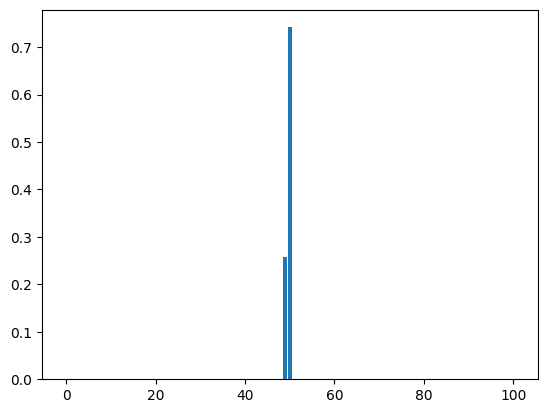

In [ ]:
plt.bar(np.arange(N.BINS_LEN), get_approximation(50, RESULTS.last[1, 0, 3, :])['x'])

In [ ]:
bits = io.BytesIO()
bits.write(blosc.compress(pickle.dumps(RESULTS)))
boto_filename = f"{N.BOTO_FILE_PREFIX}{datetime.datetime.utcnow().strftime('%Y%m%d%H%M%S_1_1')}.pkl"
bits.seek(0)
BOTO_CLIENT.upload_fileobj(bits, N.BOTO_BUCKET, boto_filename)

In [ ]:
del RESULTS, OLD_RESULTS, hist